In [52]:
library(tidyverse)
library(glue)
library(here)
library(bdkn)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 50 rows containing non-finite values (stat_smooth).”

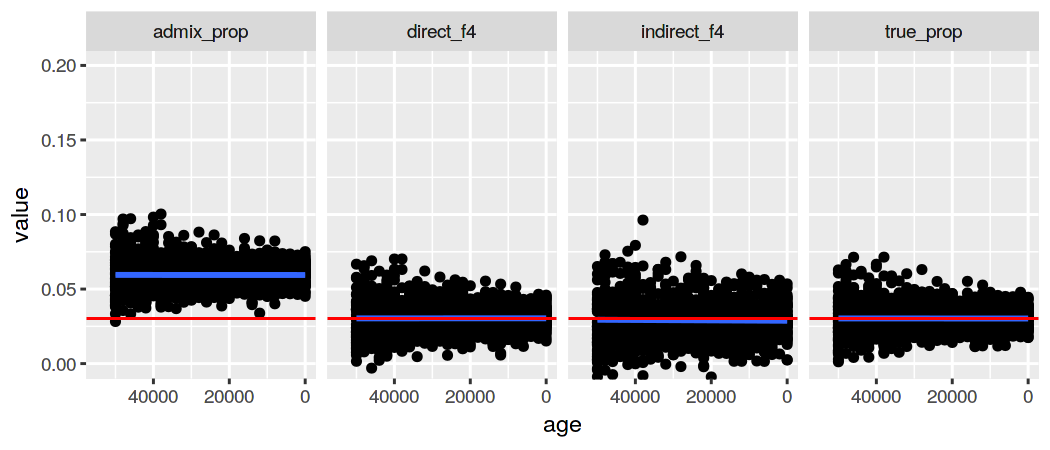

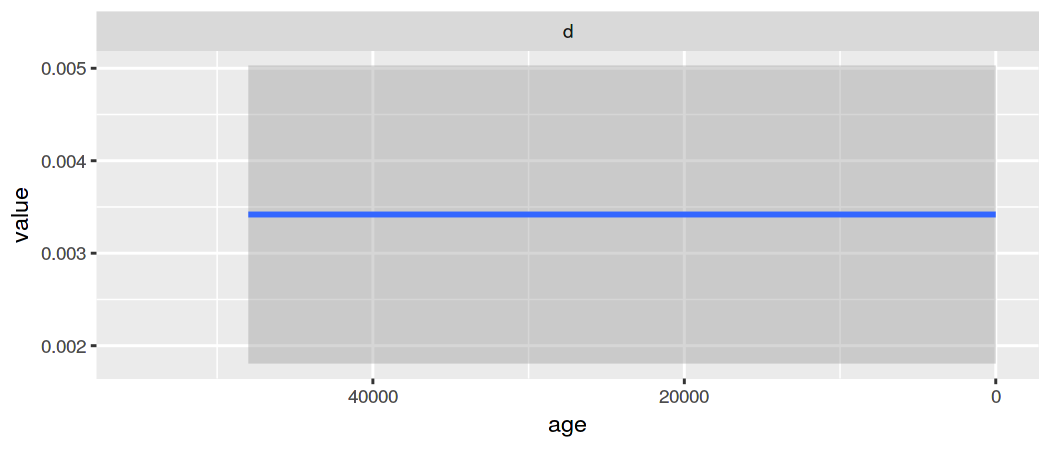

In [73]:
df <- list.files(here("."), "yoruba.*.txt", full.names = TRUE) %>% 
        map_dfr(
            ~ suppressMessages(read_tsv(.x)) %>% mutate(rep = .x)
        ) %>%
        gather(stat, value, -c(name, age, rep))

set_dim(7, 3)

filter(df, stat != "d") %>%
ggplot(aes(age, value)) + facet_grid(. ~ stat) + geom_point() + geom_smooth(method = "lm") +
    xlim(55000, 0) + coord_cartesian(y = c(0, 0.2)) + geom_hline(yintercept = 0.03, color = "red")

set_dim(7, 3)

filter(df, stat == "d") %>%
ggplot(aes(age, value)) + facet_grid(. ~ stat) + geom_smooth() + xlim(55000, 0)